In [1]:
suppressPackageStartupMessages({

    library(VariantAnnotation)
    library(tidyverse)
    library(magrittr)
    library(here)
    library(bdkn)
    library(rtracklayer)

})

In [2]:
mendez_a00_counts <- tibble(
    a = 1434, d = 305, e = 19, f = 1591,
    total = 7830000,
    ref = "reference", anc = "ustishim", age = "45000"
)

In [3]:
mendez_a00_counts

a,d,e,f,total,ref,anc,age
1434,305,19,1591,7830000,reference,ustishim,45000


In [4]:
emh_ages <- tibble(
    name = c("ustishim", "bichon", "kk1", "loschbour", "mota"),
    age = c(45000, 13665, 9720, 8050, 4500)
)
emh_ages

name,age
ustishim,45000
bichon,13665
kk1,9720
loschbour,8050
mota,4500


In [5]:
pops <- tibble(
    name = c("S_BedouinB-1", "S_Turkish-1", "S_French-1", "S_Burmese-1", 
             "S_Thai-1", "S_Finnish-2", "S_Sardinian-1", "S_Han-2", "S_Dai-2", 
             "S_Punjabi-1", "S_Saami-2", "S_Papuan-2", "S_Karitiana-1", "S_Dinka-1", 
             "S_Mbuti-1", "S_Yoruba-2", "S_Gambian-1", "S_Mandenka-1", "S_Ju_hoan_North-1", "reference"),
    pop = c("WestEur", "WestEur", "WestEur", "EastEur", "EastEur", "WestEur", "WestEur", "EastEur", "EastEur", "EastEur", 
            "WestEur", "EastEur", "EastEur", "Africa", "Africa", "Africa", "Africa", "Africa", "Africa", "reference")
)

In [6]:
source(here("src/utils.R"))

In [7]:
gt <- read_gt(here("data/vcf/merged_full.vcf.gz"))

In [8]:
modern <- colnames(gt) %>% str_subset("reference|^S_")

In [9]:
ancient <- c("kk1", "mota", "bichon", "loschbour", "ustishim")

In [10]:
site_patterns <- function(df, w, x, y, z) {
    tibble(
        a = as.integer(df[[w]] == df[[x]] & df[[y]] == df[[z]] & df[[w]] != df[[y]]),
        d = as.integer(df[[w]] == df[[x]] & df[[w]] == df[[z]] & df[[w]] != df[[y]]),
        e = as.integer(df[[w]] == df[[x]] & df[[w]] == df[[y]] & df[[w]] != df[[z]]),
        f = as.integer(df[[w]] == df[[y]] & df[[w]] == df[[z]] & df[[w]] != df[[x]])
    )
}

In [11]:
count_patterns <- function(gt, w, x, y, z) {
    df <- gt[, c(w, x, y, z)] %>% .[complete.cases(.), ]
    site_patterns(df, w, x, y, z) %>% summarise_all(sum) %>% mutate(total = nrow(df))
}

In [12]:
a00_counts <- 
    map_dfr(modern, function(ref) {
        map_dfr(ancient, function(anc) {
            count_patterns(gt, w = "chimp", x = "a00", y = ref, z = anc) %>%
                mutate(ref = ref, anc = anc)
        })
    }) %>%
        inner_join(emh_ages, by = c("anc" = "name")) %>% 
        inner_join(pops, by = c("ref" = "name"))

In [32]:
a00 <- a00_counts %>%
    mutate(
        muts_per_year = (d - e) / age,
        mut_rate = muts_per_year / total,
        tmrca_ad = (a + d) / (mut_rate * total),
        tmrca_f = f / (mut_rate * total),
        tmrca_avg = (tmrca_ad + tmrca_f) / 2,
        tmrca_ratio = tmrca_ad / tmrca_f
    )

In [34]:
head(a00)

a,d,e,f,total,ref,anc,age,pop,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,tmrca_ratio
879,119,53,865,4905031,S_BedouinB-1,kk1,9720,WestEur,0.006790123,1.384318e-09,146978.2,127390.9,137184.5,1.153757
790,257,217,921,5252103,S_BedouinB-1,mota,4500,WestEur,0.008888889,1.692444e-09,117787.5,103612.5,110700.0,1.136808
545,124,57,577,3159361,S_BedouinB-1,bichon,13665,WestEur,0.004903037,1.551908e-09,136446.0,117682.2,127064.1,1.159445
1011,209,139,1054,6011365,S_BedouinB-1,loschbour,8050,WestEur,0.008695652,1.446535e-09,140300.0,121210.0,130755.0,1.157495
990,230,20,1037,6055439,S_BedouinB-1,ustishim,45000,WestEur,0.004666667,7.706570e-10,261428.6,222214.3,241821.4,1.176471
835,138,108,861,4916318,S_Turkish-1,kk1,9720,WestEur,0.003086420,6.277909e-10,315252.0,278964.0,297108.0,1.130081


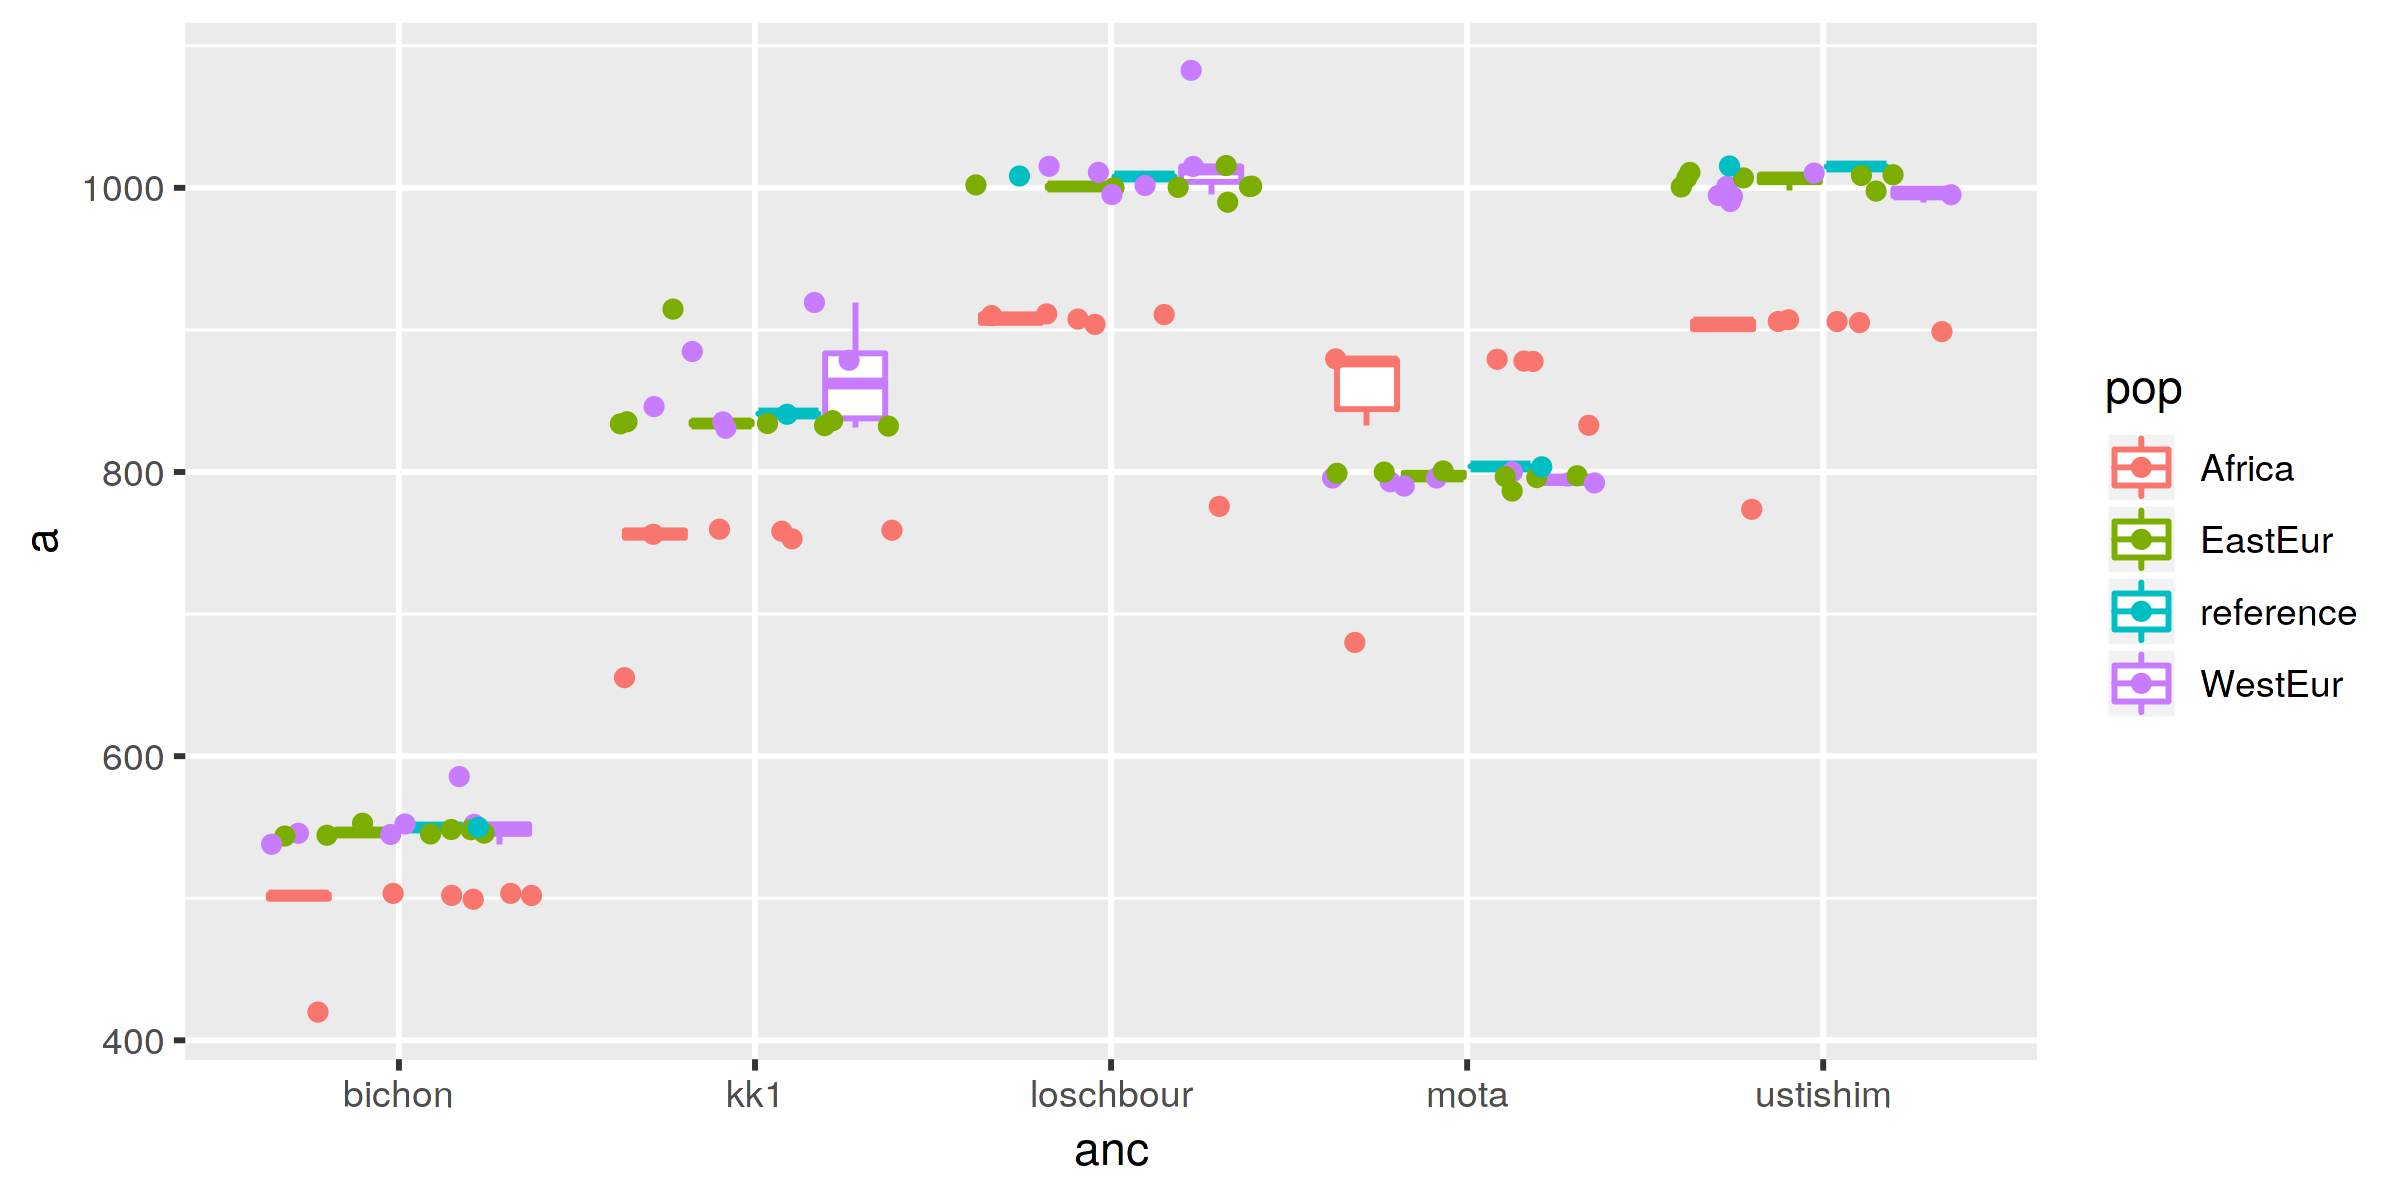

In [46]:
set_dim(8, 4, 300)

a00 %>%
ggplot(aes(anc, a, color = pop)) +
    geom_boxplot(outlier.shape = NA) + geom_jitter() + #geom_label(aes(label = ifelse(pop == "EastEur", ref, NA))) +
    NULL #+ ylim(0, 500000)

In [56]:
a00 %>% filter(anc == "ustishim") %>% .$tmrca_avg %>% mean

[1] 260459.5